Last run: Dec 11

In [2]:
import sys
sys.path.insert(0, "/ut3/jerome/github/research/project/wakai/code/")
from catalog import get_tfop_info, get_params_from_tfop, Target

In [3]:
target = "TOI-6063"
tfop_info = get_tfop_info(target)
star_params = get_params_from_tfop(tfop_info, name="stellar_parameters")
planet_params = get_params_from_tfop(tfop_info, name="planet_parameters")

In [4]:
mags = tfop_info["magnitudes"]
mags_dict = {}
for i in range(len(mags)):
    try:
        mags_dict[mags[i]['band']]=(float(mags[i]['value']),float(mags[i]['value_e']))
        print(mags[i]['band'],mags_dict[mags[i]['band']])
    except:
        pass

TESS (10.4246, 0.1318)
B (10.864, 0.13)
V (10.812, 0.012)
Gaia (10.5744, 0.001084)
J (10.387, 0.018)
H (10.396, 0.016)
K (10.386, 0.018)
WISE 3.4 micron (9.325, 0.022)
WISE 4.6 micron (9.072, 0.02)
WISE 12 micron (8.321, 0.023)
WISE 22 micron (7.385, 0.126)


In [5]:
t = Target(float(tfop_info['coordinates']['ra']),
           float(tfop_info['coordinates']['dec'])
          )

In [6]:
source = 'I/345/gaia2'
for i in ["BP","RP"]:
    v=t.query_vizier_param(i+"mag")[source]
    e=t.query_vizier_param("e_"+i+"mag")[source]
    print(i,v,e)
    mags_dict[i]=(v,e)

Found 6 references in Vizier with `BPmag`.
Found 2 references in Vizier with `e_BPmag`.
BP 10.704 0.0017
Found 6 references in Vizier with `RPmag`.
Found 2 references in Vizier with `e_RPmag`.
RP 10.3324 0.0036


In [9]:
plx = t.query_vizier_param("Plx")[source]
plx_err = t.query_vizier_param("e_Plx")[source]

Found 11 references in Vizier with `Plx`.
Found 6 references in Vizier with `e_Plx`.


In [ ]:
teff = t.query_vizier_param("Teff")[source]
teff_err = t.query_vizier_param("e_Teff")#[source]
teff, teff_err

In [10]:
from isochrones import get_ichrone, SingleStarModel

mist = get_ichrone('mist', bands=['BP','RP','J','H','K'])
params = {'Teff': (teff, teff_err), 
          #'logg': (4.62, 0.1), 
          #'feh': (-0.06, 0.08),
          'BP': mags_dict['BP'], 
          'RP': mags_dict['RP'],
          'J': mags_dict['J'],
          'H': mags_dict['H'],
          'K': mags_dict['K'],
          'parallax': (plx, plx_err)}  # mas
mod = SingleStarModel(mist, name=target, **params)

Holoviews not imported. Some visualizations will not be available.


Text(0.5, 1.0, 'FlatLogPrior')

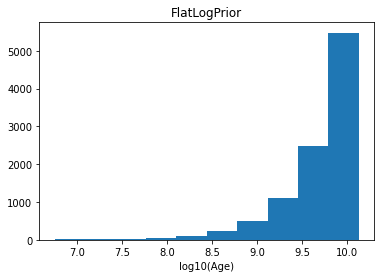

In [11]:
import matplotlib.pyplot as pl

N = 10_000
s = mod._priors['age'].sample(N)
pl.hist(s)
pl.xlabel("log10(Age)")
pl.title("FlatLogPrior")

# update priors

Text(0.5, 1.0, 'FlatPrior')

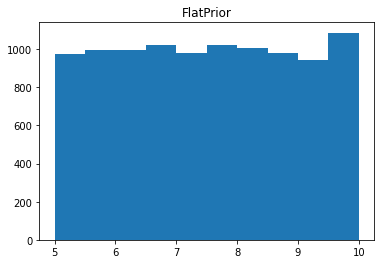

In [12]:
from isochrones.priors import FlatPrior

# change age and AV priors
mod.set_prior(age=FlatPrior(bounds=(5,10)), 
              # AV=FlatPrior(bounds=(0,0.01))
             )
s = mod._priors['age'].sample(N)
pl.hist(s);
pl.title("FlatPrior")

In [13]:
prior_samples = mod.sample_from_prior(N)
prior_samples.head()

,age,feh,distance,AV,eep
0,7.704498,-0.019583,9751.937752,0.489042,214
1,6.589109,0.073030,6082.092203,0.715601,152
2,6.797109,-0.128320,8076.867791,0.970690,109
3,7.756561,0.172985,9538.995046,0.947905,147
4,9.916780,-0.007457,5615.566106,0.482030,331


# check updated priors

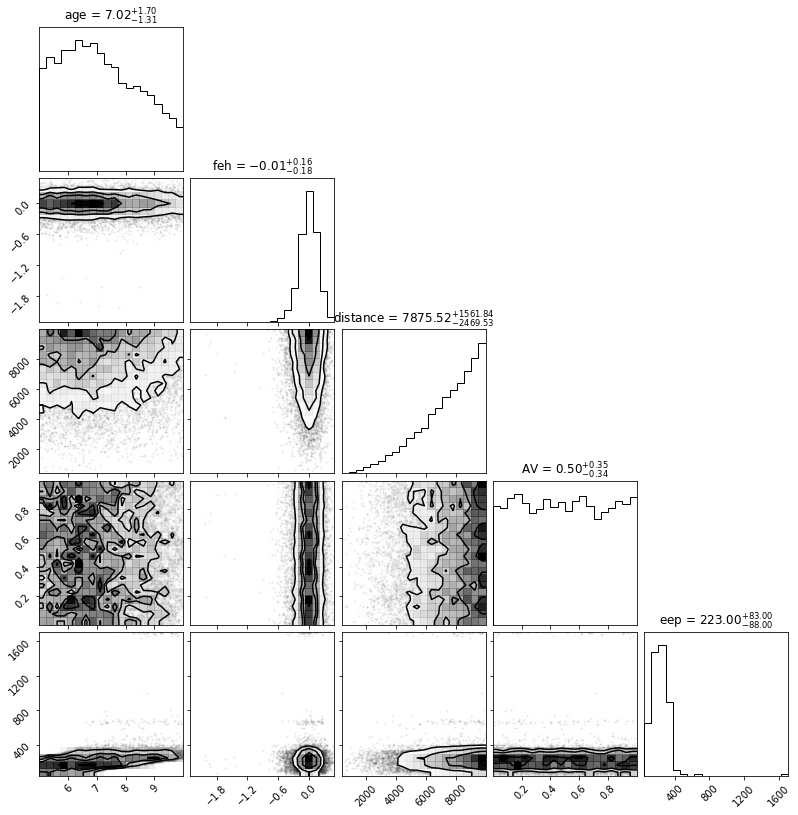

In [14]:
from corner import corner

fig = corner(prior_samples, show_titles=True, titles=prior_samples.columns)

# fit

In [15]:
mod.fit()

In [16]:
cols = ['radius','mass','Teff','logg','feh','age']
mod.derived_samples[cols]

,radius,mass,Teff,logg,feh,age
0,48.268093,0.542454,7082.157998,0.870018,0.333041,9.991115
1,53.348397,0.542956,7033.265413,0.808171,0.335359,9.982641
2,53.446499,0.542668,7073.256408,0.819614,0.344801,9.992011
3,51.990495,0.542522,7076.863304,0.838232,0.346181,9.995100
4,50.963218,0.542606,7056.975296,0.839390,0.336988,9.989859
...,...,...,...,...,...,...
6852,60.490562,0.543056,7057.974355,0.753195,0.352340,9.990002
6853,60.440501,0.543046,7064.062396,0.755525,0.353352,9.990579
6854,60.786411,0.543092,7065.090527,0.750489,0.352342,9.989461
6855,60.839783,0.543100,7068.179862,0.750179,0.352386,9.989352


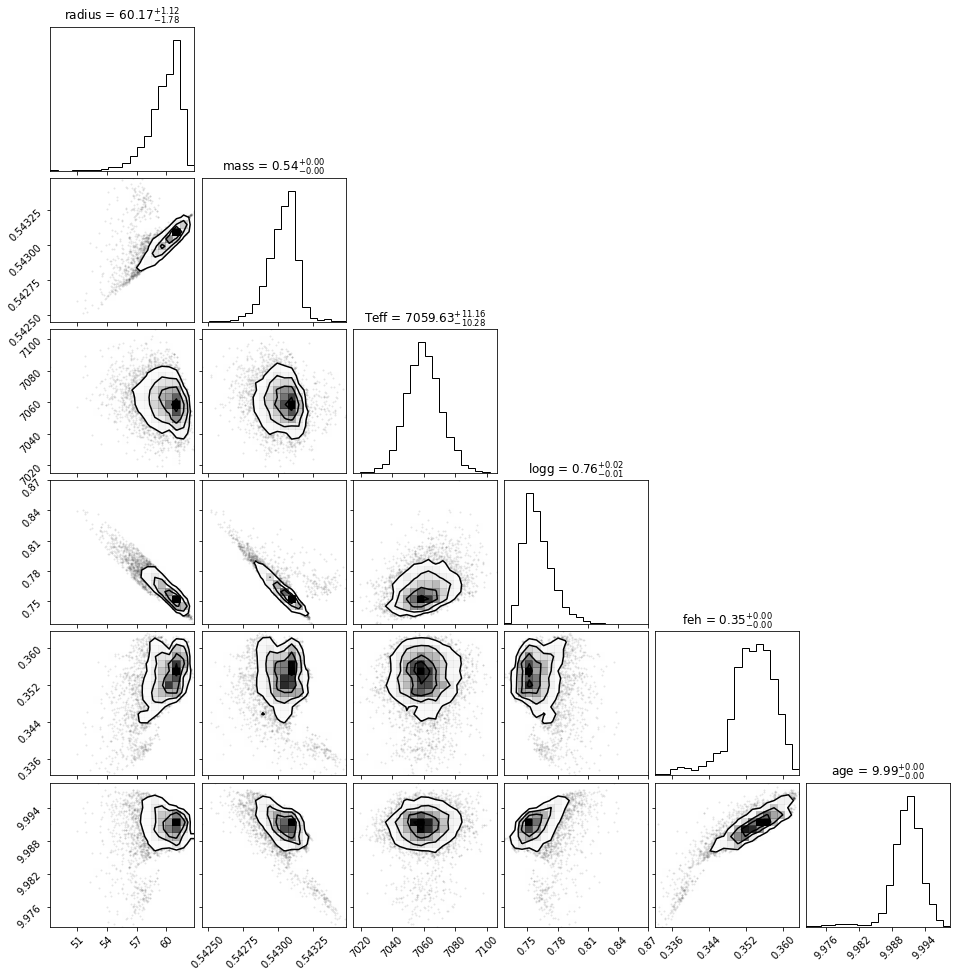

In [17]:
fig = corner(mod.derived_samples[cols], show_titles=True, titles=mod.derived_samples[cols].columns)

Text(0.5, 1.0, 'Age (Myr)')

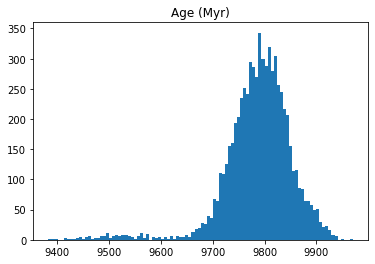

In [18]:
pl.hist(10**mod.derived_samples['age']/1e6, bins=100)
pl.title("Age (Myr)")